In [2]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore")

In [3]:
data = yf.download('TQQQ', start = '2000-01-01', end = '2024-01-01')
data['Day'] = data.index.day_of_week
data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Day
Date,,,,,,,
2010-02-11,0.406875,0.434896,0.405573,0.432552,0.418944,3456000,3
2010-02-12,0.420781,0.438073,0.418333,0.434323,0.420659,8601600,4
2010-02-16,0.444531,0.452188,0.437552,0.451146,0.436953,9619200,1
2010-02-17,0.457188,0.458906,0.450313,0.458802,0.444368,19180800,2
2010-02-18,0.458333,0.470260,0.455573,0.467500,0.452793,38860800,3
...,...,...,...,...,...,...,...
2023-12-22,50.599998,50.939999,49.639999,50.349998,49.977837,66114200,4
2023-12-26,50.639999,51.509998,50.619999,51.270000,50.891037,43685600,1
2023-12-27,51.349998,51.660000,51.020000,51.540001,51.159039,55747800,2


In [14]:
'''
Strategy:
Buy: On Tuesday or Wednesday, if the two previous days have consecutively lower closing prices, long at the open
Sell: When the close is higher than the previous day's high, sell at the close
'''
buys = []
buy_dates = []
sells = []
sell_dates = []
index = []
position = False
for i in range(len(data)):
    if data['Day'][i] == 1 or data['Day'][i] == 2:
        if i > 2 and data['Close'][i-1] < data['Close'][i-2]:
            if data['Close'][i-2] < data['Close'][i-3] and position == False:
                buys.append(data['Open'][i])
                buy_dates.append(data.index[i])
                position = True
                index.append(i)
    if position == True:
        if i > index[-1] and data['Close'][i] > data['High'][i-1]:
            sells.append(data['Close'][i])
            sell_dates.append(data.index[i])
            position = False



In [15]:
#Calculate the annualized returns of the strategy
returns = (np.array(sells) - np.array(buys)) / np.array(buys)
cumulative_return = np.prod(1 + returns) - 1
total_days = len(data)
annualized_return = (1 + cumulative_return) ** (365 / total_days) - 1
print("Annualized Return: " + str(round(annualized_return * 100, 2)), "%")

Annualized Return: 30.74 %


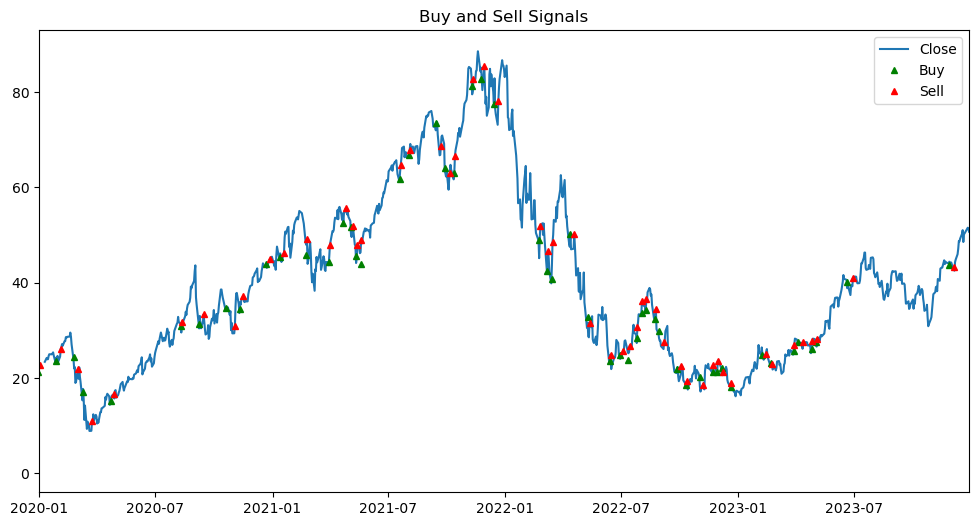

In [23]:
#Plot the buy and sell signals (shrunk to 2020 onward for better visiblity)
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 6))
plt.plot(data['Close'].iloc[-1000:])
plt.plot(buy_dates, buys, '^', color = 'g', markersize = 5)
plt.plot(sell_dates, sells, '^', color = 'r', markersize = 5)
plt.title('Buy and Sell Signals')
plt.legend(['Close', 'Buy', 'Sell'])
plt.xlim(pd.Timestamp('2020-01-01'), data.index[-1])
plt.show()



In [6]:
#Calculate the Sharpe Ratio
total_trading_days = 252

# Initialize daily returns array with zeros
daily_returns = np.zeros(total_trading_days)

# Assume trades happen on specific days (1-5)
trade_days = [1, 2, 3, 4, 5]

# Update daily returns for trading days
for i, day in enumerate(trade_days):
    daily_returns[day] = (sells[i] - buys[i]) / buys[i]

# Calculate average daily return
average_daily_return = np.mean(daily_returns)

# Calculate standard deviation of daily returns
std = np.std(daily_returns)

# Calculate Sharpe Ratio
sharpe_ratio = (average_daily_return / std) * np.sqrt(252)

# Print the Sharpe Ratio
print("Sharpe Ratio: " + str(round(sharpe_ratio, 3)))

Sharpe Ratio: 1.984
